# 1. IMPORTS
---

## 1.1. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import shap
import warnings

warnings.filterwarnings('ignore')

In [2]:
# Boruta numpy fix problem
np.int = np.int32
np.float = np.float64
np.bool = np.bool_

# 2. FEATURE SELECTION
---

In [3]:
# Import train and test data
X_train_rescaled = pd.read_csv('../data/processed/X_train_rescaled.csv')

X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')

X_test_rescaled = pd.read_csv('../data/processed/X_test_rescaled.csv')

X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

# Drop ID
for dataset in [X_train, X_test, X_train_rescaled, X_test_rescaled]:
    dataset.drop('id', axis=1, inplace=True)

# Data to numpy
X_train_rescaled_n = X_train_rescaled.values
y_train_n = y_train.values.ravel()

## 2.1. Boruta

I'll use Random Forest for Boruta algorithm. It's just a generalist forest model to input in.

In [4]:
## Boruta as feature selector - WARNING: 20 minutes to run
#
## Define the Boruta feature selector
#rfb = RandomForestClassifier(class_weight='balanced',            # class_weight='balanced' 
#                             max_depth=5, n_estimators=100)      # IS IMPORTANT FOR IMBALANCED DATA
#
#fs = BorutaPy(rfb, n_estimators='auto', random_state=42, 
#              verbose=2, max_iter=100)
#
## Fit the feature selector
#fs.fit(X_train_rescaled_n, y_train_n)
#
## Get the selected features
#selected_features = X_train.columns[fs.support_]
#print(selected_features)

In [5]:
boruta_features = [
    'age', 'annual_premium', 'vintage', 'famous_region', 'vehicle_age',
    'vehicle_age2', 'hi_customer_profitability',
    'famous_policy_sales_channel', 'policy_sales_channel2_124',
    'policy_sales_channel2_152', 'policy_sales_channel2_26', 'gender'
]

## 2.2. RF Feature Importances

In [6]:
# Fitting Random Forest
rffi = RandomForestClassifier(class_weight='balanced',            # class_weight='balanced' 
                              max_depth=5, n_estimators=100)      # IS IMPORTANT FOR IMBALANCED DATA

rffi.fit(X_train_rescaled, y_train_n)

RandomForestClassifier(class_weight='balanced', max_depth=5)

In [7]:
# Feature Importances
rf_imp_features = pd.Series(rffi.feature_importances_, index=X_train_rescaled.columns)
rf_imp_features = rf_imp_features.sort_values()

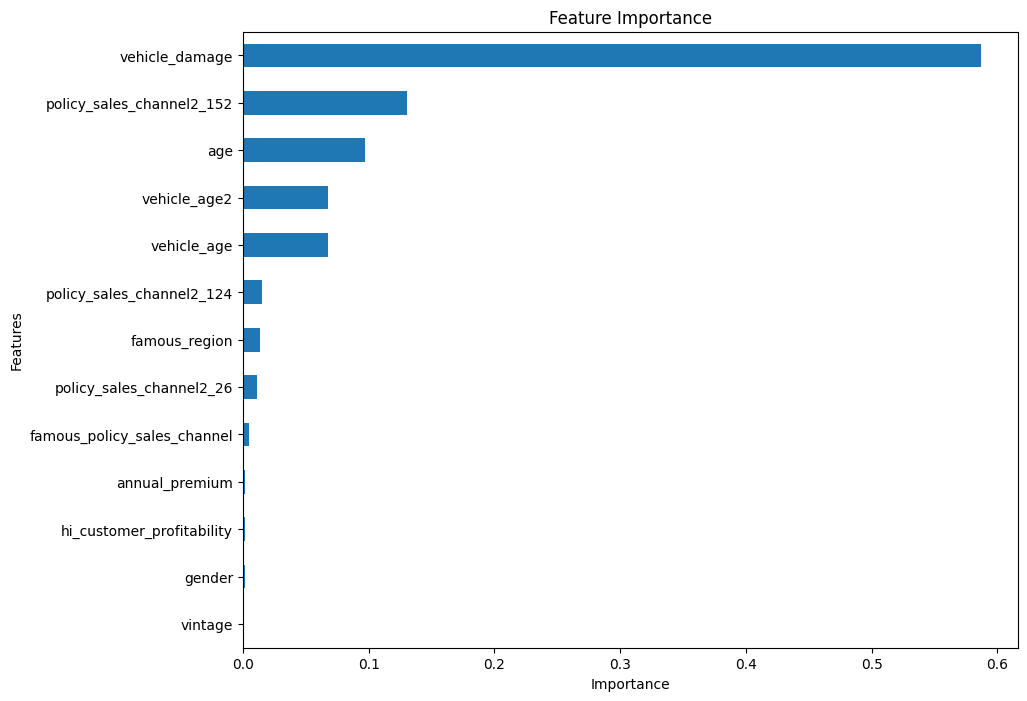

In [8]:
# Plot feature importances
plt.figure(figsize=(10, 8))
rf_imp_features.plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

In Random Forest feature importances:
- `vehicle_age2` was less important than `vehicle_age`
- `famous_policy_sales_channel` was less important than the `152`, `124` and `26` channels separately
- The most important variable is `vehicle_damage`

## 2.3. SHAP Values

In [9]:
# Fitting Random Forest
rfs = RandomForestClassifier(class_weight='balanced',            # class_weight='balanced' 
                             max_depth=5, n_estimators=100)      # IS IMPORTANT FOR IMBALANCED DATA

rfs.fit(X_train_rescaled, y_train_n)

# Initialize explainer with the training data
explainer = shap.TreeExplainer(rfs)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_rescaled)

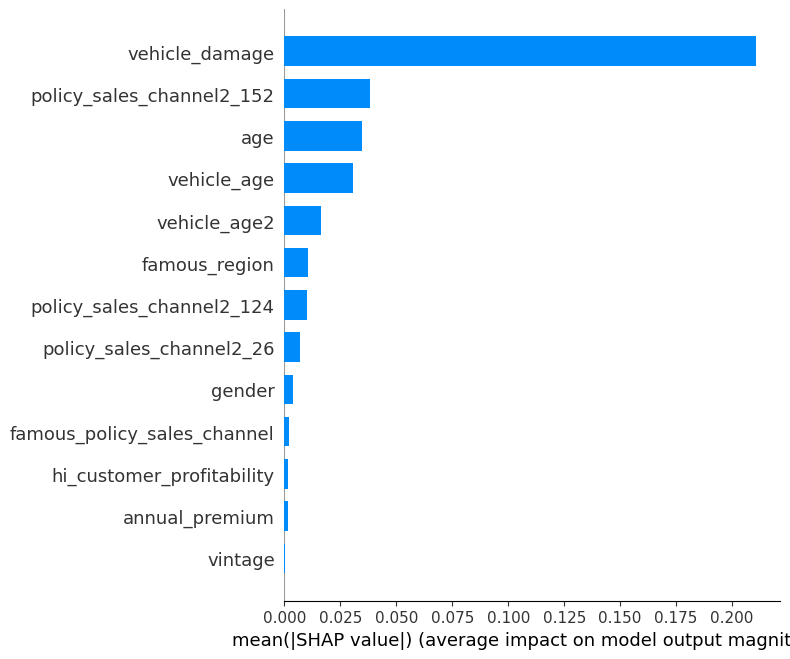

In [10]:
# SHAP feature importance plot
shap.summary_plot(shap_values[:,:,1], X_train_rescaled,
                  feature_names=X_train_rescaled.columns,
                  plot_type='bar')
plt.show()

`vehicle_age2` and `vehicle_age` have almost the same importance...

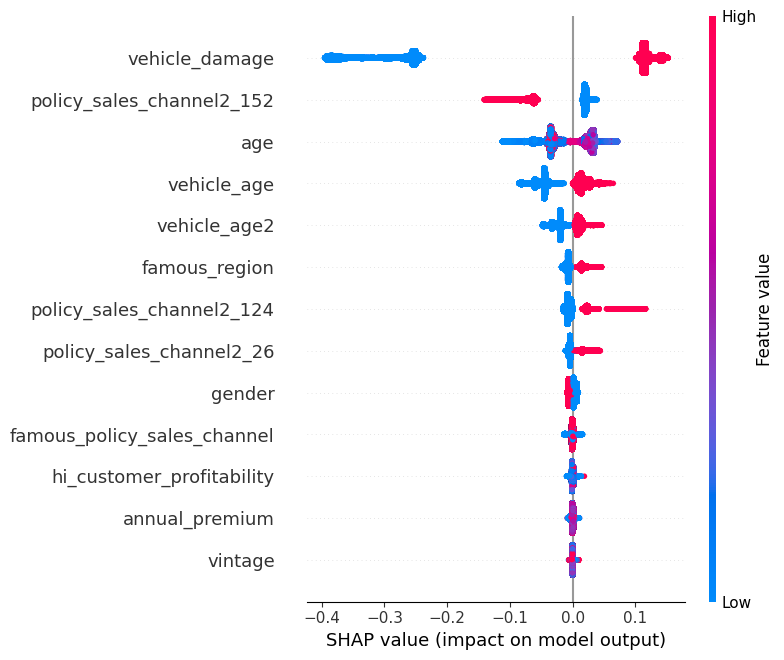

In [11]:
# SHAP beeswarm plot
shap.summary_plot(shap_values[:,:,1], X_train_rescaled,
                  feature_names=X_train_rescaled.columns)
plt.show()

Basically, the **health insurance features aren't important for the business question**. **Maybe we could offer the vehicle insurance separetedly, or cross-sell with another product of the company...**

## 2.4. Decision

From **EDA**, **RF Feature Importances** and **SHAP plots**, the less important features are:
- `vintage`
- `hi_customer_profitability`
- `annual_premium`

I won't drop `gender` because maybe it is important for this business case.

Furthermore, there are some features high correlated with others:
- `famous_policy_sales_channel`: `152`, `124` and `26`
- `vehicle_age2`: `vehicle_age` (I could choose any of them)

So, I'll drop `famous_policy_sales_channel` and `vehicle_age2`.